# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
df.to_csv('real_estate_data.csv', index=False)
df.info()
df.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.0",108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,"18,863.0","16,028.0",1.0,482.0,2.0,755.0,NaN
1,7,"3,350,000.0",40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,"12,817.0","18,603.0",0.0,NaN,0.0,NaN,81.0
2,10,"5,196,000.0",56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,"21,741.0","13,933.0",1.0,90.0,2.0,574.0,558.0
3,0,"64,900,000.0",159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,"28,098.0","6,800.0",2.0,84.0,3.0,234.0,424.0
4,2,"10,000,000.0",100.0,2018-06-19T00:00:00,2,3.0,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,"31,856.0","8,098.0",2.0,112.0,1.0,48.0,121.0


### Вывод

Название столбцов записаны в верном формате. Разное количество пропусков в разных столбцах.

## Предобработка данных

In [99]:
df.duplicated().sum()# дубликатов нет

0

In [100]:
# подсчитаем пропущенные значения в каждом столбце
for name in df.columns:
    display(f"Пропущенных значений в '{name}'-{df[name].isna().sum()} шт.")

"Пропущенных значений в 'total_images'-0 шт."

"Пропущенных значений в 'last_price'-0 шт."

"Пропущенных значений в 'total_area'-0 шт."

"Пропущенных значений в 'first_day_exposition'-0 шт."

"Пропущенных значений в 'rooms'-0 шт."

"Пропущенных значений в 'ceiling_height'-9195 шт."

"Пропущенных значений в 'floors_total'-86 шт."

"Пропущенных значений в 'living_area'-1903 шт."

"Пропущенных значений в 'floor'-0 шт."

"Пропущенных значений в 'is_apartment'-20924 шт."

"Пропущенных значений в 'studio'-0 шт."

"Пропущенных значений в 'open_plan'-0 шт."

"Пропущенных значений в 'kitchen_area'-2278 шт."

"Пропущенных значений в 'balcony'-11519 шт."

"Пропущенных значений в 'locality_name'-49 шт."

"Пропущенных значений в 'airports_nearest'-5542 шт."

"Пропущенных значений в 'cityCenters_nearest'-5519 шт."

"Пропущенных значений в 'parks_around3000'-5518 шт."

"Пропущенных значений в 'parks_nearest'-15620 шт."

"Пропущенных значений в 'ponds_around3000'-5518 шт."

"Пропущенных значений в 'ponds_nearest'-14589 шт."

"Пропущенных значений в 'days_exposition'-3181 шт."

Пропуски буду заменять только в столбце по количеству балконов. 
Остальные пропуски средним или медианным значением считаю нельзя заменять, расчеты будут не верные.

In [101]:
#пропущенные значения в столбце количество балконов изменяю на 0, тип данных на int
df['balcony'] = df['balcony'].fillna(0)
df['balcony'].isna().sum()
df['balcony'] = df['balcony'].astype('int')

пропущенные значения в столбце количество балконов изменил на 0, тип данных на "int"

### Вывод

Провел предобработку данных. В большинстве столбцов не хватает числовых значений. Заменять их средними или медианными значениями не буду, так как это может повлиять на исследование. В столбце с количеством балконов, заменил пропущенные значения на 0 (отсутствует балкон)

## Расчёты и добавление результатов в таблицу

In [102]:
#добавил цену квадратного метра
df['metr_price'] = df['last_price'] / df['total_area']
df['metr_price'] = df['metr_price'].astype('int')
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price
0,20,"13,000,000.0",108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,...,0,Санкт-Петербург,"18,863.0","16,028.0",1.0,482.0,2.0,755.0,NaN,120370
1,7,"3,350,000.0",40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,2,посёлок Шушары,"12,817.0","18,603.0",0.0,NaN,0.0,NaN,81.0,82920
2,10,"5,196,000.0",56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,0,Санкт-Петербург,"21,741.0","13,933.0",1.0,90.0,2.0,574.0,558.0,92785
3,0,"64,900,000.0",159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,0,Санкт-Петербург,"28,098.0","6,800.0",2.0,84.0,3.0,234.0,424.0,408176
4,2,"10,000,000.0",100.0,2018-06-19T00:00:00,2,3.0,14.0,32.0,13,NaN,...,0,Санкт-Петербург,"31,856.0","8,098.0",2.0,112.0,1.0,48.0,121.0,100000


In [103]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d %H:%M')
df['day'] = df['first_day_exposition'].dt.weekday
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,day,month,year
0,20,"13,000,000.0",108.0,2019-03-07,3,2.7,16.0,51.0,8,NaN,...,"16,028.0",1.0,482.0,2.0,755.0,NaN,120370,3,3,2019
1,7,"3,350,000.0",40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,"18,603.0",0.0,NaN,0.0,NaN,81.0,82920,1,12,2018
2,10,"5,196,000.0",56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,"13,933.0",1.0,90.0,2.0,574.0,558.0,92785,3,8,2015
3,0,"64,900,000.0",159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,...,"6,800.0",2.0,84.0,3.0,234.0,424.0,408176,4,7,2015
4,2,"10,000,000.0",100.0,2018-06-19,2,3.0,14.0,32.0,13,NaN,...,"8,098.0",2.0,112.0,1.0,48.0,121.0,100000,1,6,2018


добавил день недели, месяц и год публикации объявления

In [104]:
#добавил этаж квартиры; варианты — первый, последний, другой

# варианты где не указано количество этажей в доме, будет принадлежать к типу другой. 
#Погрешность получится только для типа последний, так как первый сразу вылетит.

def floors(df):
    if df['floor'] == 1:
        return 'первый'
    elif df['floor'] == df['floors_total']:
        return 'последний'
    elif df['floor'] != df['floors_total']:
        return 'другой'
    
df['type_floor'] = df.apply(floors, axis=1)
df.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,day,month,year,type_floor
0,20,"13,000,000.0",108.0,2019-03-07,3,2.7,16.0,51.0,8,NaN,...,1.0,482.0,2.0,755.0,NaN,120370,3,3,2019,другой
1,7,"3,350,000.0",40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,0.0,NaN,0.0,NaN,81.0,82920,1,12,2018,первый
2,10,"5,196,000.0",56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,1.0,90.0,2.0,574.0,558.0,92785,3,8,2015,другой
3,0,"64,900,000.0",159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,...,2.0,84.0,3.0,234.0,424.0,408176,4,7,2015,другой
4,2,"10,000,000.0",100.0,2018-06-19,2,3.0,14.0,32.0,13,NaN,...,2.0,112.0,1.0,48.0,121.0,100000,1,6,2018,другой


In [105]:
#добавил соотношение жилой и общей площади
df['ratio_living'] = df['living_area'] / df['total_area']

In [106]:
#добавил отношение площади кухни к общей площади
df['ratio_kitchen'] = df['kitchen_area'] / df['total_area']
df.head(5)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,metr_price,day,month,year,type_floor,ratio_living,ratio_kitchen
0,20,"13,000,000.0",108.0,2019-03-07,3,2.7,16.0,51.0,8,NaN,...,2.0,755.0,NaN,120370,3,3,2019,другой,0.5,0.2
1,7,"3,350,000.0",40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,0.0,NaN,81.0,82920,1,12,2018,первый,0.5,0.3
2,10,"5,196,000.0",56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,2.0,574.0,558.0,92785,3,8,2015,другой,0.6,0.1
3,0,"64,900,000.0",159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,...,3.0,234.0,424.0,408176,4,7,2015,другой,NaN,NaN
4,2,"10,000,000.0",100.0,2018-06-19,2,3.0,14.0,32.0,13,NaN,...,1.0,48.0,121.0,100000,1,6,2018,другой,0.3,0.4


## Исследовательский анализ данных

count   23,699.0
mean        60.3
std         35.7
min         12.0
25%         40.0
50%         52.0
75%         69.9
max        900.0
Name: total_area, dtype: float64

<AxesSubplot:>

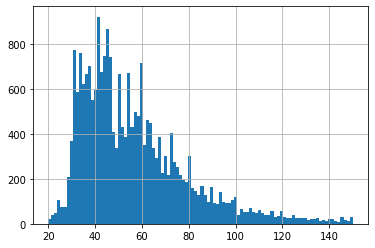

In [107]:
display(df['total_area'].describe())
pd.options.display.float_format = '{:,.1f}'.format
#гистограмму общей площади строю выбрав диапазон значений от 20 до 150
df['total_area'].hist(range=(20, 150),bins=100)

Из гистограммы видно что наибольшее число объявлений с площадью от 30 до 80 кв. м.

count        23,699.0
mean      6,541,548.8
std      10,887,013.3
min          12,190.0
25%       3,400,000.0
50%       4,650,000.0
75%       6,800,000.0
max     763,000,000.0
Name: last_price, dtype: float64

<AxesSubplot:>

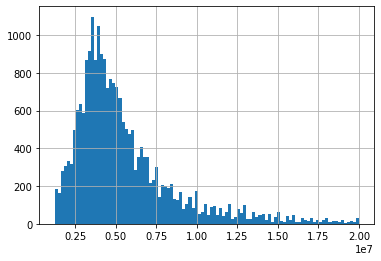

In [108]:
display(df['last_price'].describe())
pd.options.display.float_format = '{:,.1f}'.format
#гистраграмму цены строю в диапозоне от минимального значения до 20 000 000
df['last_price'].hist(range=(1219000, 20000000),bins=100)

С помощью гистрограммы видно что большая часть квартир, находится в диапозоне от 2 до 7 млн. рублей.

count   23,699.0
mean         2.1
std          1.1
min          0.0
25%          1.0
50%          2.0
75%          3.0
max         19.0
Name: rooms, dtype: float64

<AxesSubplot:>

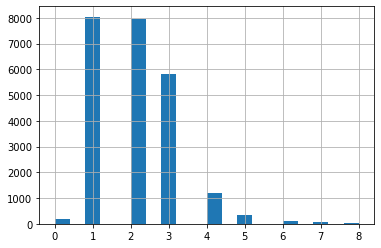

In [109]:
display(df['rooms'].describe())
pd.options.display.float_format = '{:,.1f}'.format
# гистограмму количество комнат строю в диапозоне от 0 до 8
df['rooms'].hist(range=(0, 8), bins=20)

Большая часть квартир это 1 -2 -3 комнатные.

count   14,504.0
mean         2.8
std          1.3
min          1.0
25%          2.5
50%          2.6
75%          2.8
max        100.0
Name: ceiling_height, dtype: float64

<AxesSubplot:>

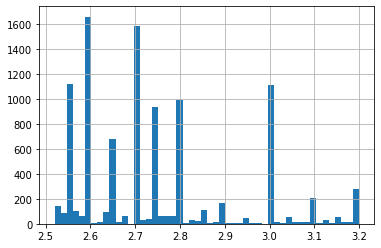

In [110]:
display(df['ceiling_height'].describe())
pd.options.display.float_format = '{:,.1f}'.format
# гистограмму высоты потолков буду строить по данным между 1 и 3 квартилем. 
df['ceiling_height'].hist(range=(2.52, 3.20),bins=50)

Наибольшее число объявлений с высотой 2.60 и 2.70 метров

задание: "Изучите время продажи квартиры. Постройте гистограмму. 
Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. 
Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"

count   20,518.0
mean       180.9
std        219.7
min          1.0
25%         45.0
50%         95.0
75%        232.0
max      1,580.0
Name: days_exposition, dtype: float64

<AxesSubplot:>

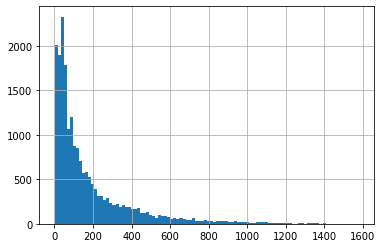

In [111]:
display(df['days_exposition'].describe())
pd.options.display.float_format = '{:,.1f}'.format
df['days_exposition'].hist( bins=100)

Вывод: Среднее значение продажи квартиры 180 дней. Медианное значение продажи квартиры 95 дней.
Из-за нескольких больших значений продажи квартиры, среднее время продажи отражает не верную картину происходящего. 
Продажи до 100 дней считаю быстрыми, свыше 400 дней необычно долгими

Задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."

<AxesSubplot:>

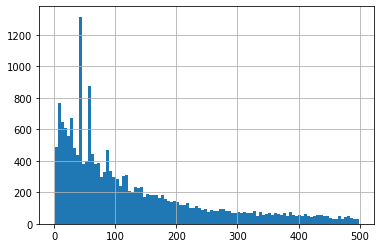

In [112]:
df_days_exposition = df.query('days_exposition < 500') #убрал дни продажи более 500
df_days_exposition['days_exposition'].hist(bins=100)

Вывод: Подтвердилось, что продажи до 100 дней считаю быстрыми, а необычно долгими стали свыше 250 дней

Выбивающие значения (площади, цены, числа комнат и высота потолков) буду убирать методом query в ходе определения зависимости от этих показателей ниже, в ходе исследования.

Задание: 
"Какие факторы больше всего влияют на стоимость квартиры? 
Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. 
Также изучите зависимость от даты размещения: дня недели, месяца и года. 
"Выберите 10 населённых пунктов с наибольшим числом объявлений. 
Посчитайте среднюю цену квадратного метра в этих населённых пунктах. 
Выделите населённые пункты с самой высокой и низкой стоимостью жилья. 
Эти данные можно найти по имени в столбце 'locality_name'. "

0.6536750579657242

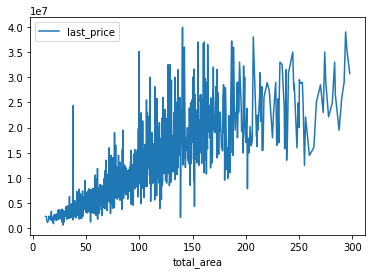

In [113]:
# проверим зависит ли цена от площади

df_price = df.query('last_price < 40000000 & total_area < 300')
df_price = df_price.pivot_table(index='total_area', values=['last_price'], aggfunc='mean')
df_price.plot()
df['total_area'].corr(df['last_price'])

Вывод: чем больше площадь квартиры, тем выше цена


0.3633428499648948

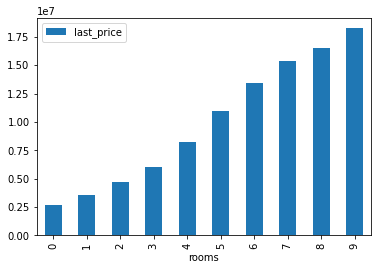

In [114]:
# проверим зависит ли цена от числа комнат

df_rooms = df.query('last_price < 20000000 & rooms < 10')
df_rooms = df_rooms.pivot_table(index='rooms', values=['last_price'], aggfunc='median')
df_rooms.plot(kind='bar')
df['last_price'].corr(df['rooms'])

Вывод: Стоимость квартиры напрямую зависит от количества комнат исходя из графика.
Хотя коэффициент корреляции показывает не сильную связь

<AxesSubplot:xlabel='type_floor'>

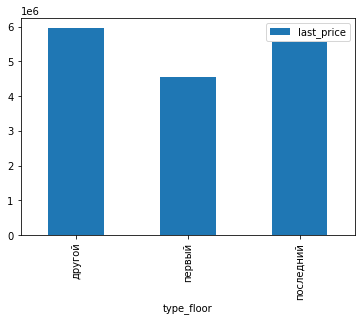

In [115]:
# проверим зависит ли цена от этажа

df_floor = (df.query('last_price < 30000000').
            pivot_table(index='type_floor', values=['last_price'], aggfunc='mean'))
df_floor.plot(kind='bar')

Вывод: стоимость первого этажа дешевле, но разница не большая

<AxesSubplot:xlabel='cityCenters_nearest'>

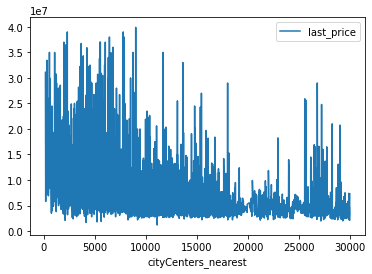

In [116]:
# проверим зависит ли цена от удалённости от центра

df_rest = (df.query('last_price < 40000000 & cityCenters_nearest < 30000').
           pivot_table(index='cityCenters_nearest', values='last_price', aggfunc='mean'))
df_rest.plot()

 Вывод: чем дальше от центра, тем меньше дорогих квартир

<AxesSubplot:xlabel='day'>

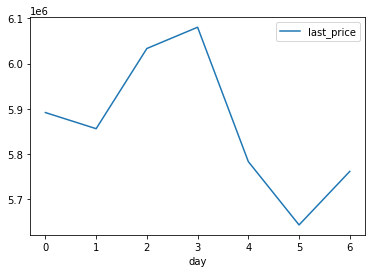

In [117]:
# изучим зависимость цены от даты размещения: дня недели, месяца и года.
df_day = (df.query('last_price < 40000000 & last_price > 400000').
           pivot_table(index='day', values=['last_price'], aggfunc='mean'))
df_day.plot()

Вывод: цена c понедельника по четверг самая высокая

<AxesSubplot:xlabel='month'>

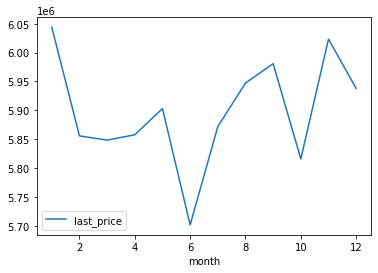

In [118]:
df_month = (df.query('last_price < 40000000 & last_price > 400000').
           pivot_table(index='month', values=['last_price'], aggfunc='mean'))
df_month.plot()

Вывод: В июне выставляется на продажа самая низкая стоимость недвижимости

<AxesSubplot:title={'center':'year'}, xlabel='year'>

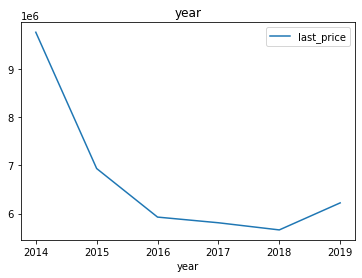

In [119]:
df_year = (df.query('last_price < 40000000 & last_price > 400000').
           pivot_table(index='year', values=['last_price'], aggfunc='mean'))
df_year.plot(title='year')

Вывод: Стоимость недвижимости опускалась до 2018 года, затем пошла вверх

In [120]:
#"Выберите 10 населённых пунктов с наибольшим числом объявлений. 
#Посчитайте среднюю цену квадратного метра в этих населённых пунктах. 
df_top = df.pivot_table(index='locality_name', values='metr_price', aggfunc=['count', 'mean'])
df_top.columns = ['count', 'mean_metr_price']
df_top = df_top.sort_values(by='count', ascending=False)
df_top.head(10)

,count,mean_metr_price
locality_name,,
Санкт-Петербург,15721,"114,848.6"
посёлок Мурино,522,"85,751.7"
посёлок Шушары,440,"78,676.9"
Всеволожск,398,"68,654.0"
Пушкин,369,"103,125.4"
Колпино,338,"75,424.2"
посёлок Парголово,327,"90,175.5"
Гатчина,307,"68,745.7"
деревня Кудрово,299,"92,473.1"


Вывод: выделил 10 пунктов с наибольшим числом объявлений и нашел среднюю цену квадратного метра

In [121]:
#Выделите населённые пункты с самой высокой и низкой стоимостью жилья. 
city_max = df_top.loc[df_top['mean_metr_price'] == df_top['mean_metr_price'].max()]
display(city_max)
city_min = df_top.loc[df_top['mean_metr_price'] == df_top['mean_metr_price'].min()]
city_min

,count,mean_metr_price
locality_name,,
посёлок Лисий Нос,2,"121,615.5"


,count,mean_metr_price
locality_name,,
деревня Старополье,3,"11,206.0"


Вывод: Самая высокая стоимость жилья в посёлок Лисий Нос. Самая низкая в деревня Старополье.

In [122]:
#выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. 
#Выделите квартиры в Санкт-Петербурге ('locality_name'). 
#Ваша задача — выяснить, какая область входит в центр. 
#Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. 
#После этого посчитайте среднюю цену для каждого километра. 
#Постройте график: он должен показывать, как цена зависит от удалённости от центра. 
#Определите границу, где график сильно меняется — это и будет центральная зона. "

In [123]:
df_km = df[df['locality_name'] == 'Санкт-Петербург']
df_km.dropna(subset=['cityCenters_nearest'], inplace=True) # удалил пропущенные значения в столбце расстояние до центра
df_km['km'] = (df_km['cityCenters_nearest'] / 1000).astype('int')
df_km.head(10)

/tmp/ipykernel_58/1231499175.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_km.dropna(subset=['cityCenters_nearest'], inplace=True) # удалил пропущенные значения в столбце расстояние до центра
/tmp/ipykernel_58/1231499175.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_km['km'] = (df_km['cityCenters_nearest'] / 1000).astype('int')


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,metr_price,day,month,year,type_floor,ratio_living,ratio_kitchen,km
0,20,"13,000,000.0",108.0,2019-03-07,3,2.7,16.0,51.0,8,NaN,...,755.0,NaN,120370,3,3,2019,другой,0.5,0.2,16
2,10,"5,196,000.0",56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,574.0,558.0,92785,3,8,2015,другой,0.6,0.1,13
3,0,"64,900,000.0",159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,...,234.0,424.0,408176,4,7,2015,другой,NaN,NaN,6
4,2,"10,000,000.0",100.0,2018-06-19,2,3.0,14.0,32.0,13,NaN,...,48.0,121.0,100000,1,6,2018,другой,0.3,0.4,8
7,5,"7,915,000.0",71.6,2019-04-18,2,NaN,24.0,NaN,22,NaN,...,NaN,NaN,110544,3,4,2019,другой,NaN,0.3,11
9,18,"5,400,000.0",61.0,2017-02-26,3,2.5,9.0,43.6,7,NaN,...,NaN,289.0,88524,6,2,2017,другой,0.7,0.1,15
10,5,"5,050,000.0",39.6,2017-11-16,1,2.7,12.0,20.3,3,NaN,...,553.0,137.0,127525,3,11,2017,другой,0.5,0.2,13
15,16,"4,650,000.0",39.0,2017-11-18,1,NaN,14.0,20.5,5,NaN,...,296.0,19.0,119230,5,11,2017,другой,0.5,0.2,14
16,11,"6,700,000.0",82.0,2017-11-23,3,3.0,5.0,55.6,1,NaN,...,NaN,397.0,81707,3,11,2017,первый,0.7,0.1,10
17,6,"4,180,000.0",36.0,2016-09-09,1,NaN,17.0,16.5,7,NaN,...,859.0,571.0,116111,4,9,2016,другой,0.5,0.3,14


<AxesSubplot:xlabel='km'>

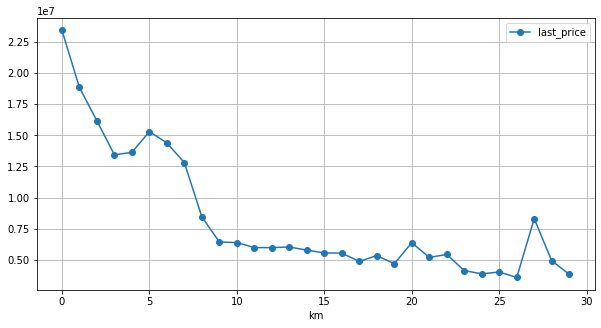

In [124]:
#После этого посчитайте среднюю цену для каждого километра. 
#Постройте график: он должен показывать, как цена зависит от удалённости от центра. 
#Определите границу, где график сильно меняется — это и будет центральная зона. "
df_km_table = df_km.pivot_table(index='km', values='last_price', aggfunc='mean')
df_km_table.plot(style='o-', grid=True, figsize=(10,5))

Вывод: по графику опредилил центральную зону равную 7 км.

задание: "Выделите сегмент квартир в центре. 
Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. 
Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). 
Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"

In [125]:
#Выделил сегмент квартир в центре. 
df_centr = df_km[df_km['km'] <= 7]
df_centr.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,ponds_around3000,ponds_nearest,days_exposition,metr_price,day,month,year,ratio_living,ratio_kitchen,km
count,"3,712.0","3,712.0","3,712.0","3,712.0","2,408.0","3,705.0","3,406.0","3,712.0","3,362.0","3,712.0",...,"3,712.0","2,660.0","3,104.0","3,712.0","3,712.0","3,712.0","3,712.0","3,406.0","3,362.0","3,712.0"
mean,10.3,"14,729,617.5",92.3,2.8,3.1,7.2,53.9,4.3,14.4,0.3,...,1.3,464.5,245.1,"144,404.4",2.5,6.4,"2,017.2",0.6,0.2,4.2
std,6.0,"24,704,514.2",60.5,1.5,0.9,4.0,37.4,3.1,9.3,0.8,...,1.1,270.3,271.4,"91,844.6",1.7,3.5,1.1,0.1,0.1,1.8
min,0.0,"1,600,000.0",12.0,0.0,2.0,2.0,2.0,1.0,2.0,0.0,...,0.0,22.0,3.0,"15,345.0",0.0,1.0,"2,014.0",0.0,0.0,0.0
25%,6.0,"6,590,000.0",56.0,2.0,2.8,5.0,31.0,2.0,9.0,0.0,...,0.0,227.0,60.0,"100,000.0",1.0,3.0,"2,017.0",0.5,0.1,3.0
50%,10.0,"9,000,000.0",77.8,3.0,3.0,6.0,45.0,4.0,12.0,0.0,...,1.0,450.5,139.5,"123,629.0",3.0,6.0,"2,017.0",0.6,0.2,4.0
75%,15.0,"14,131,375.0",108.7,3.0,3.3,9.0,65.0,5.0,16.8,0.0,...,2.0,667.0,342.0,"154,965.5",4.0,10.0,"2,018.0",0.7,0.2,5.0
max,50.0,"763,000,000.0",900.0,19.0,32.0,27.0,409.7,25.0,112.0,5.0,...,3.0,"1,293.0","1,572.0","1,907,500.0",6.0,12.0,"2,019.0",1.0,0.6,7.0


<AxesSubplot:>

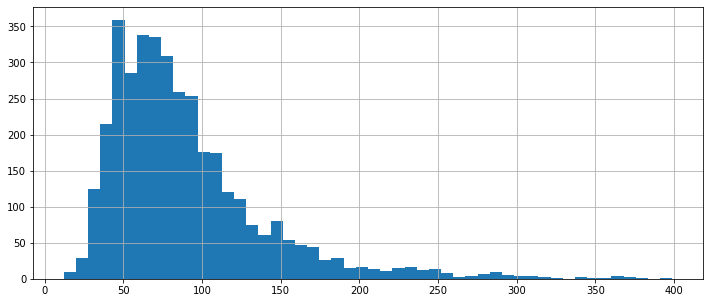

In [126]:
#Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков.

df_centr.query('total_area < 400')['total_area'].hist(bins=50, figsize=(12,5))


Вывод: основная часть квартир в центре площадью от 30 до 120 квадратных метров

<AxesSubplot:>

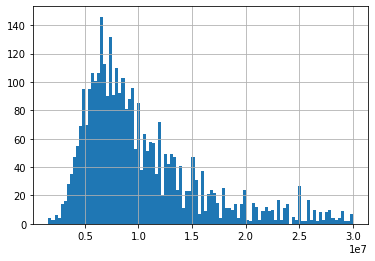

In [127]:
df_centr.query('last_price < 30000000')['last_price'].hist(bins=100)

Вывод: основная часть недвижимость стоимостью от 5 до 14 млн.

<AxesSubplot:>

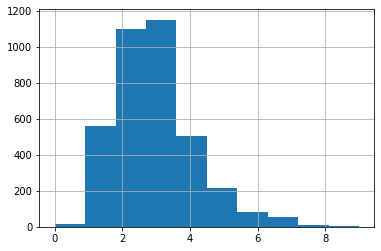

In [128]:
df_centr.query('rooms < 10')['rooms'].hist(bins=10)

Вывод: больше всего двух и трехкомнатных квартир

<AxesSubplot:>

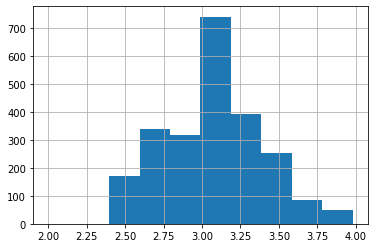

In [129]:
df_centr.query('ceiling_height < 4')['ceiling_height'].hist(bins=10)

Вывод: в среднем высота потолко от 2,7 до 3,5 м.

выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). 

<AxesSubplot:xlabel='rooms'>

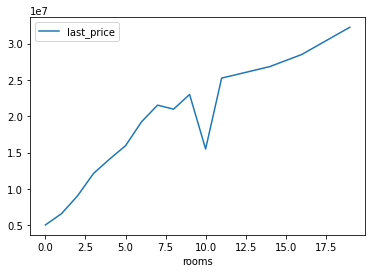

In [130]:
#число комнат
df_room = (df_centr.query('last_price < 40000000 & last_price > 1000000').
           pivot_table(index='rooms', values=['last_price'], aggfunc='mean'))
df_room.plot()

Вывод: чем больше комнат, тем больше цена квартир

<AxesSubplot:xlabel='floor'>

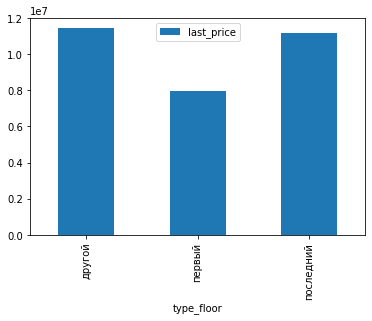

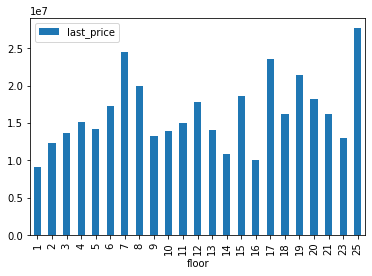

In [131]:
# этаж
df_floor = (df_centr.query('last_price < 40000000 & last_price > 1000000').
           pivot_table(index='type_floor', values=['last_price'], aggfunc='mean'))
df_floor.plot(kind='bar')
df_floor_1 = (df_centr.query('last_price < 300000000').
           pivot_table(index='floor', values=['last_price'], aggfunc='mean'))
df_floor_1.plot(kind='bar')

вывод: первый этаж дешевле других, но разница не большая

<AxesSubplot:xlabel='km'>

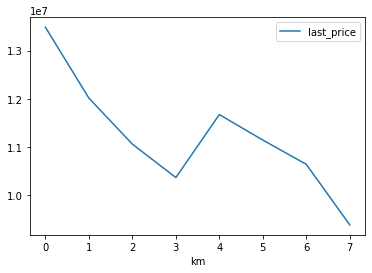

In [132]:
#удалённость от центра
df_distance = (df_centr.query('last_price < 40000000 & last_price > 1000000').
           pivot_table(index='km', values=['last_price'], aggfunc='mean'))
df_distance.plot()

вывод: в самом центре стоимость жилья самая высокая

<AxesSubplot:xlabel='day'>

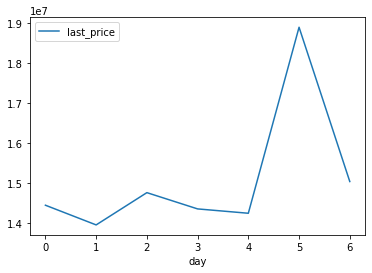

In [133]:
#день размещения объявления
df_day = (df_centr.query('last_price > 100000').
           pivot_table(index='day', values=['last_price'], aggfunc='mean'))
df_day.plot()

вывод: в выходные выставляют на продажу самую дорогую недвижимость

<AxesSubplot:xlabel='month'>

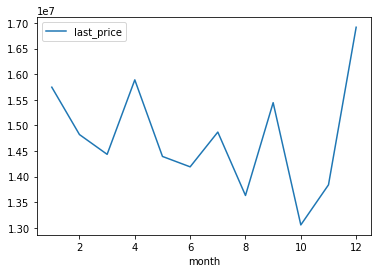

In [134]:
#месяц размещения объявления
df_month = (df_centr.query('last_price > 100000').
           pivot_table(index='month', values=['last_price'], aggfunc='mean'))
df_month.plot()

вывод: сильной зависимости размещения объявления по месяцам нет

<AxesSubplot:xlabel='year'>

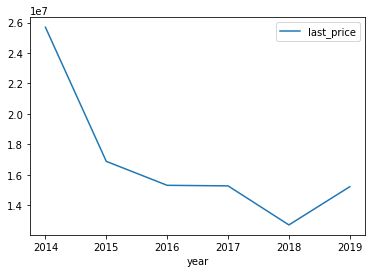

In [135]:
#год размещения объявления
df_year = (df_centr.query('last_price > 100000').
           pivot_table(index='year', values=['last_price'], aggfunc='mean'))
df_year.plot()

Вывод: стоимость жилья до 2018 года опускалась, после пошла вверх

## Общий вывод

Сравнил стоимость недвижимости в центре и за ее пределами. 
Стоимость недвижимости в центре и за ее пределами до 2018 года опускалась, после пошла вверх.
По таким характеристикам как число комнат, этаж, высота потолков показатели схожи.
В центре самая дорогая недвижимость выставляется на продажу в выходные, а за пределами центра наоборот. 
Самая высокая стоимость жилья оказалась в посёлки Лисий Нос, самая низкая в деревне Старополье.